In [1]:
import pandas as pd
import numpy as np

from warnings import filterwarnings

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

import pmdarima as pm


# Импортируем библиотеки визуализации
from matplotlib import pyplot as plt
%matplotlib inline

filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


##  Статистические модели прогнозирования.

1) Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

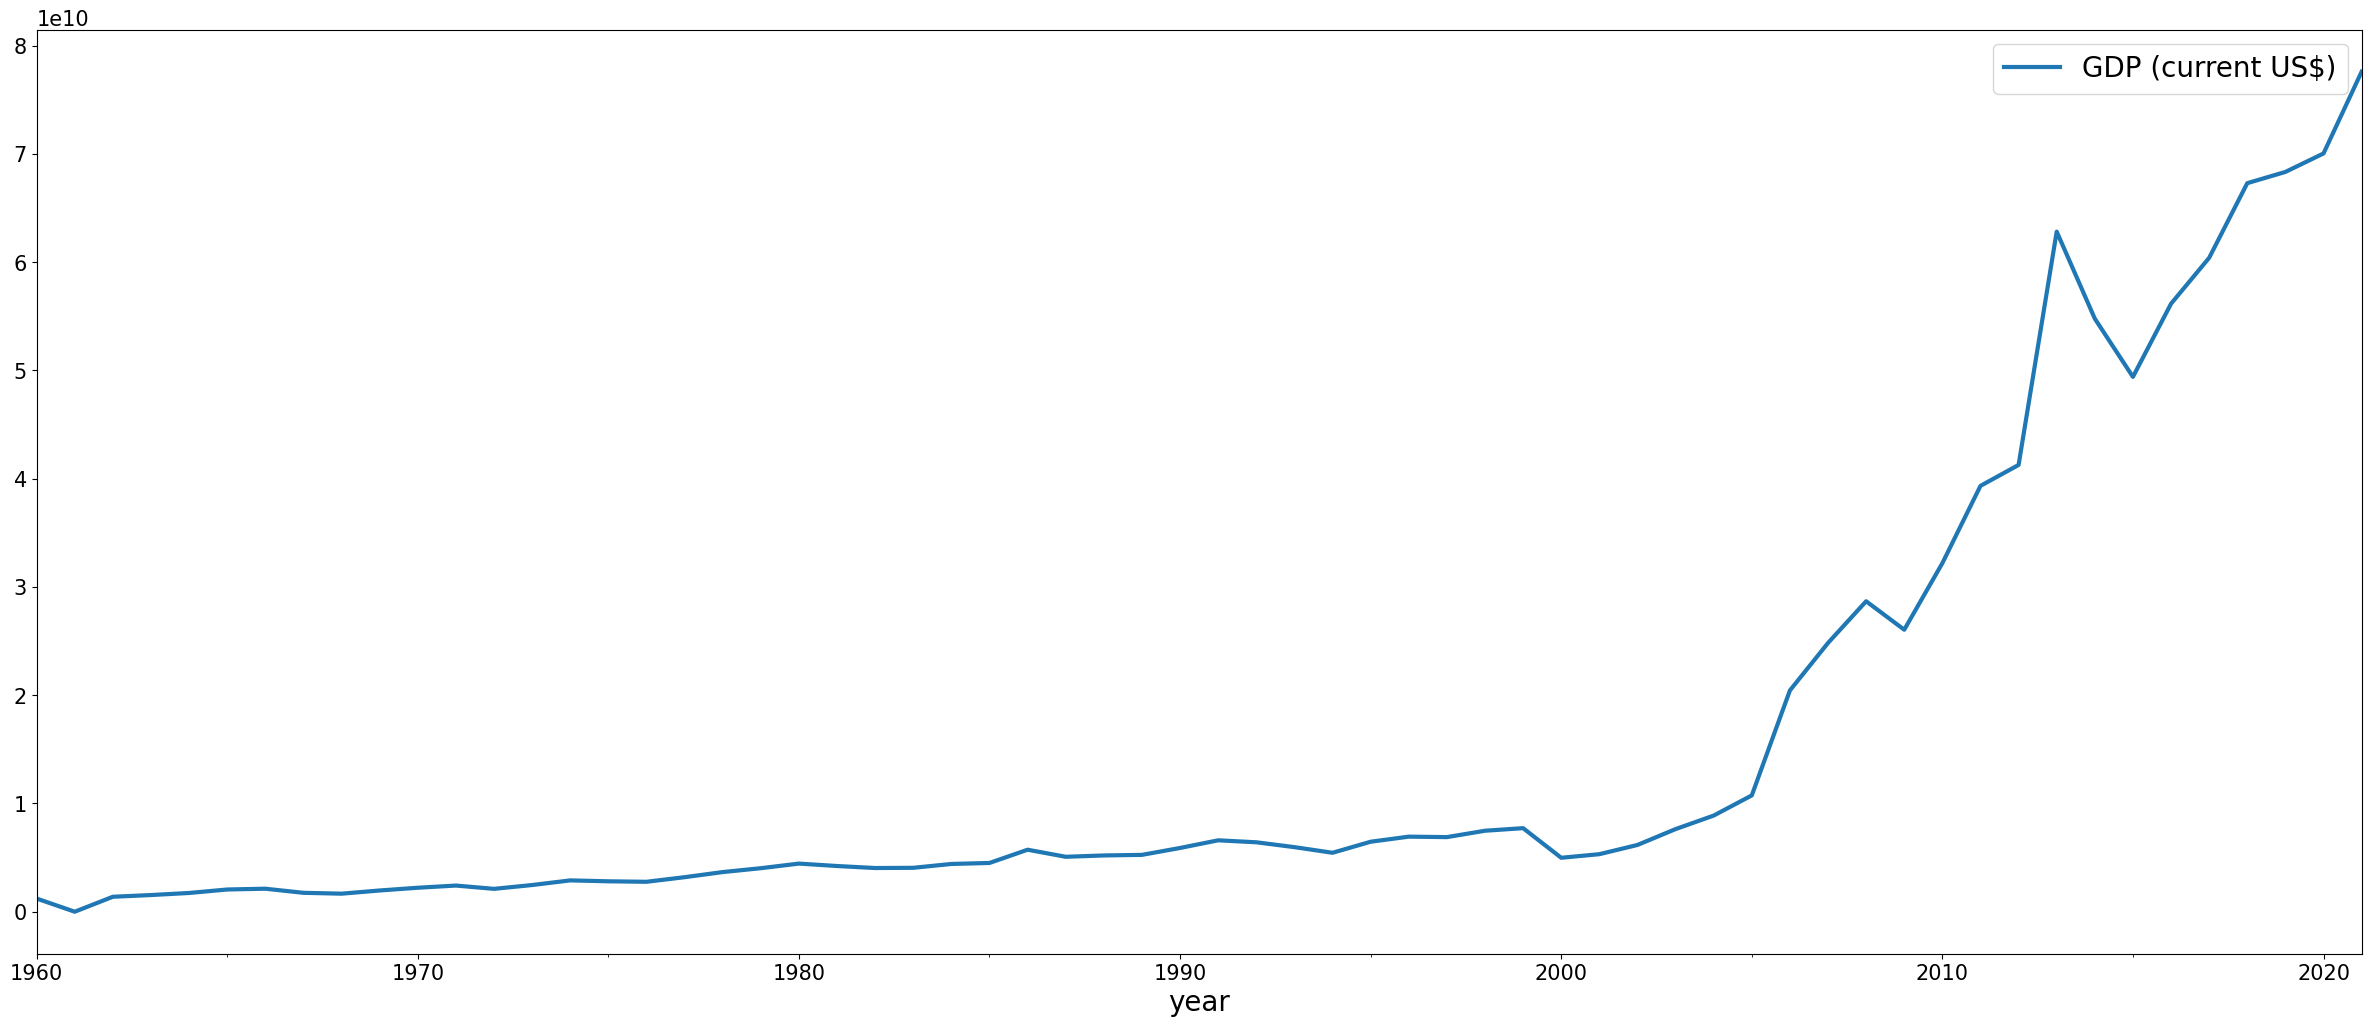

In [4]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

Вывод: Сезонности не видно, данные дополняются раз в год. По графику можно сделать вывод, что тренд растет.

In [5]:
# Разделим выборку на обучающую и тестовую
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

2) График скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно. Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

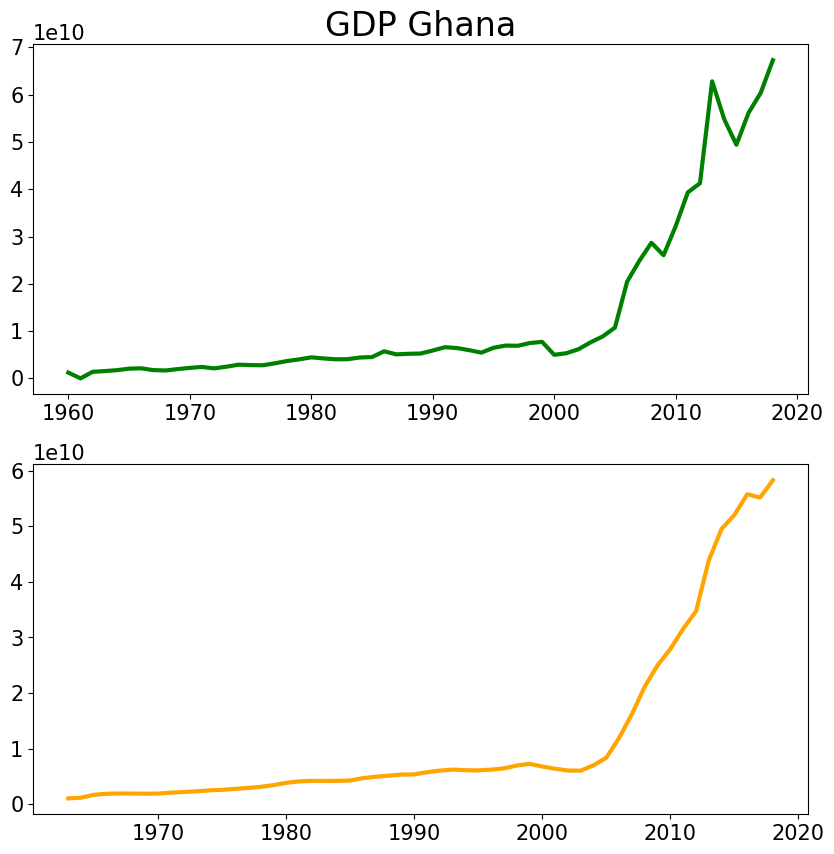

In [6]:
plt.rcParams["figure.figsize"] = 10, 10

fig, ax = plt.subplots(2)

# Окно в месяц 
ax[0].plot(train_df["GDP (current US$)"], 
           color="green", 
           label="GDP Ghana")
ax[0].set_title("GDP Ghana", size=24)

ax[1].plot(
    train_df["GDP (current US$)"].rolling(window=4).mean(),
    color="orange",
    label="Smoothed GDP Ghana",
)

Вывод: После сглаживания по графику хорошо виден четкий тренд на рост. Можно сказать с 2005 без сильных падений ВВП Ганы постоянно растет.

3) С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

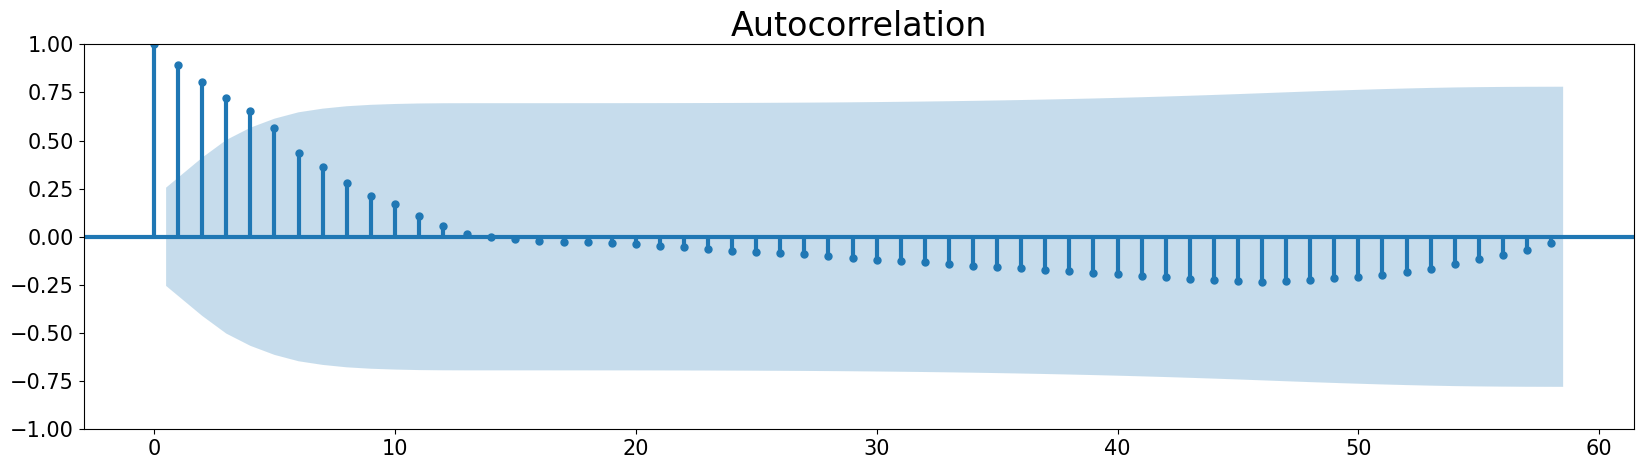

In [7]:
# посмотрим автокорреляцию
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df["GDP (current US$)"], lags=np.arange(len(train_df)), zero=False)
plt.show()

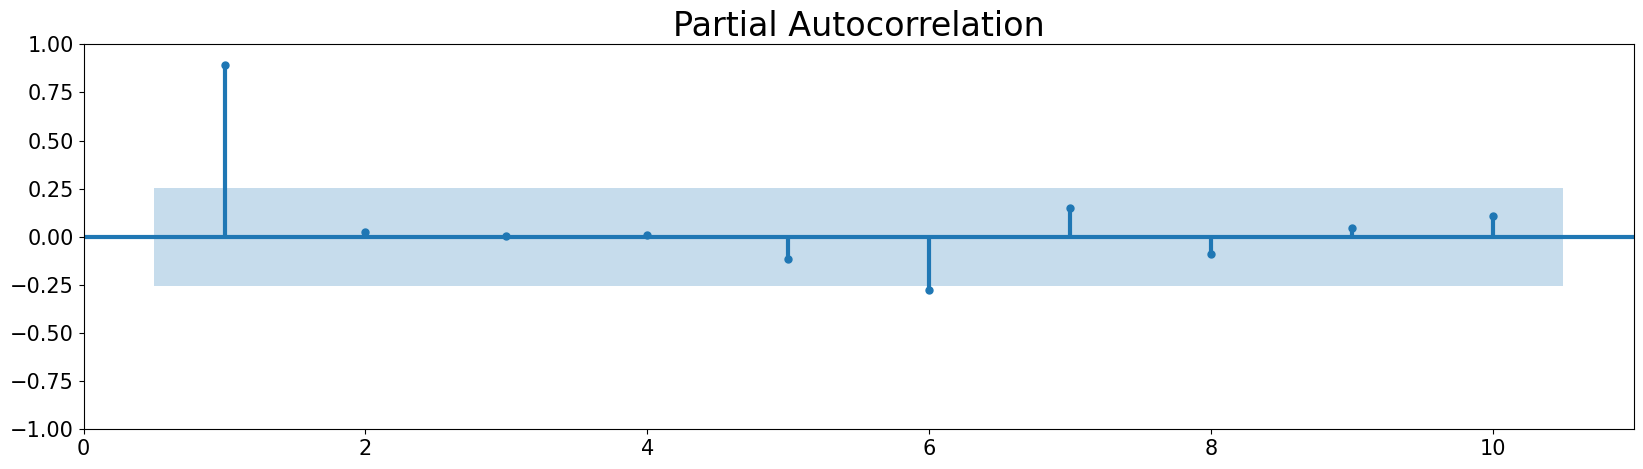

In [8]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df["GDP (current US$)"], lags=10, method="ywm", zero=False)
plt.show()

In [10]:
# создадим функцию для теста Дики-Фуллера, которая возвращает результат теста и информацию
# о стационарности 
def test_diki_fyller(series):
    test_df = adfuller((series))
    print("adf: ", test_df[0])
    print("p-value: ", test_df[1])
    print("Critical values: ", test_df[4])
    if test_df[0] > test_df[4]["5%"]:
        return("ряд нестационарен")
    else:
        return("ряд стационарен")

# теста Дики-Фуллера 
test_diki_fyller(train_df["GDP (current US$)"])

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


'ряд нестационарен'

Ряд нестационарен, необходимо его дифференцировать.

In [41]:
# дифференцирование ряда
test_diki_fyller(train_df["GDP (current US$)"].diff(2).dropna())

adf:  -3.5836708658260297
p-value:  0.006080989753876957
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}


'ряд стационарен'

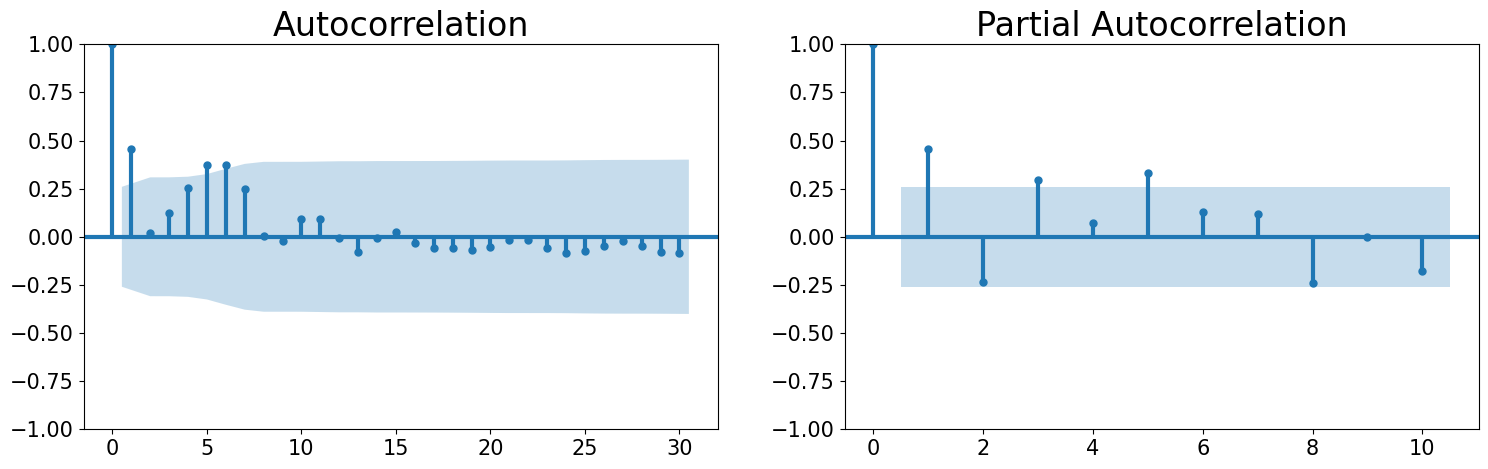

In [44]:
# функция визуализации acf и pacf
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=30)
    sgt.plot_pacf(series, ax=axes[1], lags=10, method="ywm")
    plt.show()
    
plot_acf_pacf(train_df["GDP (current US$)"].diff(2).dropna())

Выборею модель для построения ARIMA, так как ряд нестационарный (имеет тренд).

p = 1, d = 2, q = 1

In [30]:
# построение модели ARIMA
arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Wed, 20 Sep 2023   AIC                           2684.416
Time:                        14:10:05   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

AIC равен 2684.416.

Попробуем подберать еще параметры для ARIMA с помощью пакета pmdarima.

In [35]:
smodel = pm.auto_arima(
    train_df["GDP (current US$)"],
    d=2,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.33 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.50 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.40 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.19 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.65 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.75 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]          
Total fit time: 4.113 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 20 Sep 2023   AIC                           2680.765
Time:                        14:12:17   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.35e+54. Standard errors may be unstable.
"""

In [53]:
arima_model_best = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_best_fit = arima_model_best.fit()
arima_model_best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 20 Sep 2023   AIC                           2680.765
Time:                        14:19:56   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.35e+54. Standard errors may be unstable.
"""

AIC равен 2680.765. Эта модель лучше предыдущей. Поэтому использовать будем ее.

4) Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [54]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = arima_model_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

5) Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза. Сделайте выводы по полученным результатам.

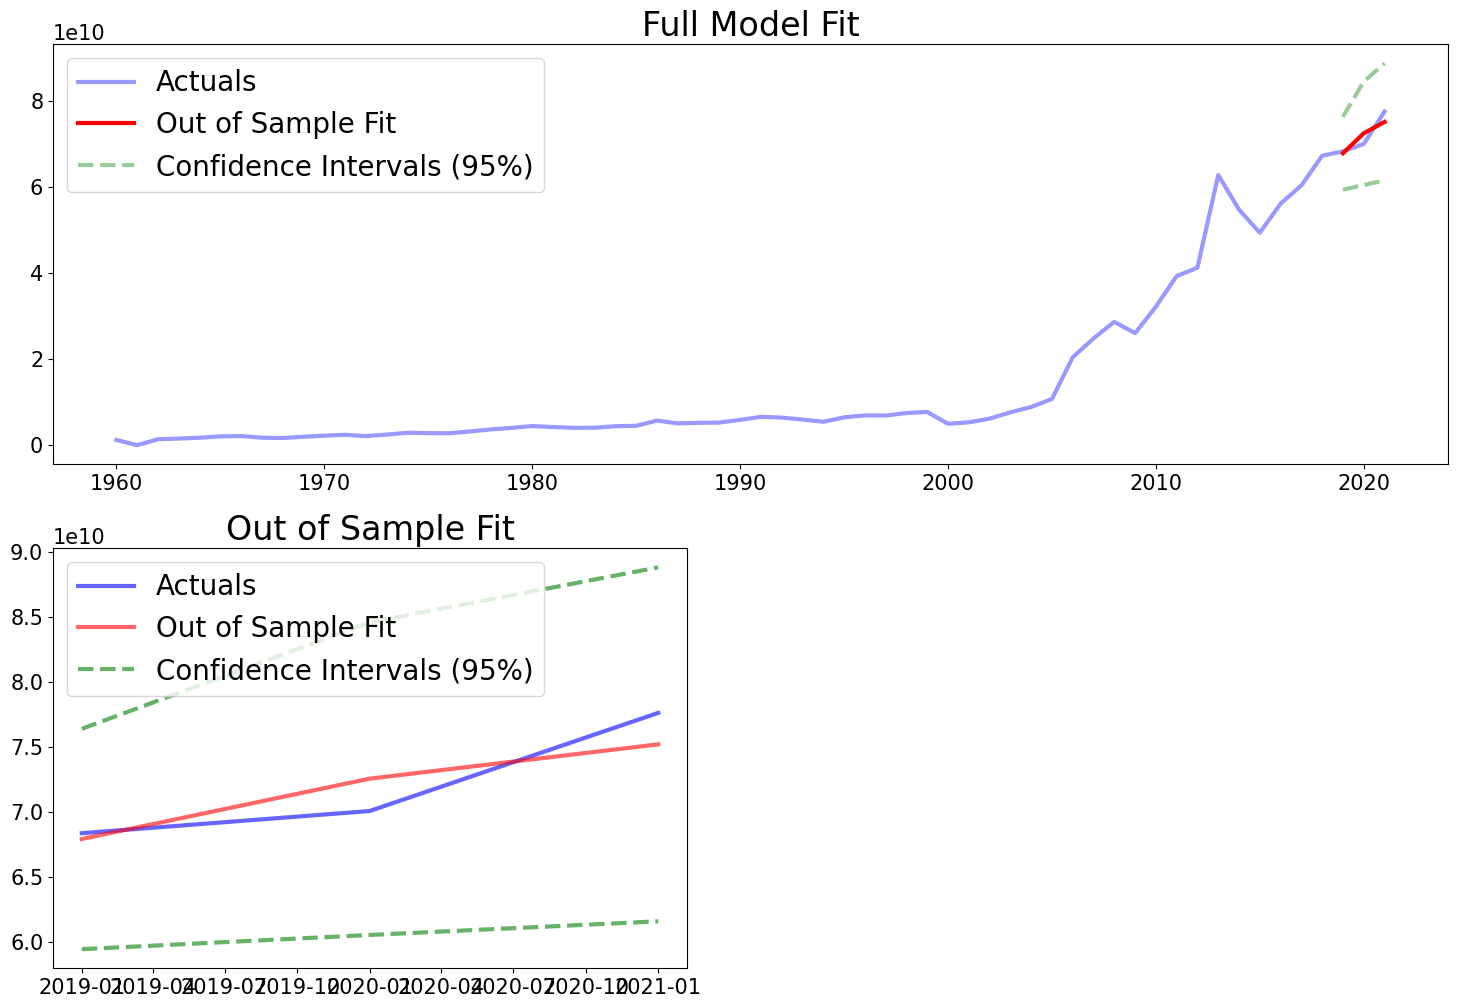

In [55]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

По графику видно, что модель уловила тренд на рост. Значение не совпадает, но ошибка в рамках интервала. Можно сказать модель правильно смогла прогнозировать, как минимум на не большой промежуток времени.(в тестовой выборке было 3 года).

# Интерполяция и сэмплирование.

1) Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц.

In [56]:
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [57]:
df.isna().sum()

GDP (current US$)    0
dtype: int64

In [58]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [59]:
df.isna().sum()

GDP (current US$)    1
dtype: int64

Видим 1 пропуск, который раньше обозначался 0.

2) Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [60]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

3) Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [61]:
# Разделим выборку на обучающую и тестовую
train_df_inter = df.loc[:"2018-01-01"]
test_df_inter = df.loc["2019-01-01":]

# теста Дики-Фуллера 
test_diki_fyller(train_df_inter["GDP (current US$)"])

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


'ряд нестационарен'

In [64]:
# дифференцирование ряда
adfuller(train_df_inter["GDP (current US$)"].diff(2).dropna())

(-3.999803440949147,
 0.0014115408436661371,
 11,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 2097.033254524892)

In [65]:
smodel_inter = pm.auto_arima(
    train_df_inter,
    start_p=1,
    d=2,
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel_inter.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.60 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.40 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.15 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.47 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.84 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]          
Total fit time: 3.755 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 20 Sep 2023   AIC                           2680.513
Time:                        14:22:19   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+55. Standard errors may be unstable.
"""

In [66]:
arima_model_inter = ARIMA(train_df_inter["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_inter_fit = arima_model_inter.fit()
arima_model_inter_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 20 Sep 2023   AIC                           2680.513
Time:                        14:22:31   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+55. Standard errors may be unstable.
"""

AIC равен 2680.513.

4) Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

AIC изменился стал меньше и равен 2680.513. Модель стала лучше по данном показателю, следовательно должно более точно предсказывать.

In [67]:
pred_df = pd.DataFrame(index=df.index)


pred_df["model_preds"] = arima_model_inter_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = arima_model_inter_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%


pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

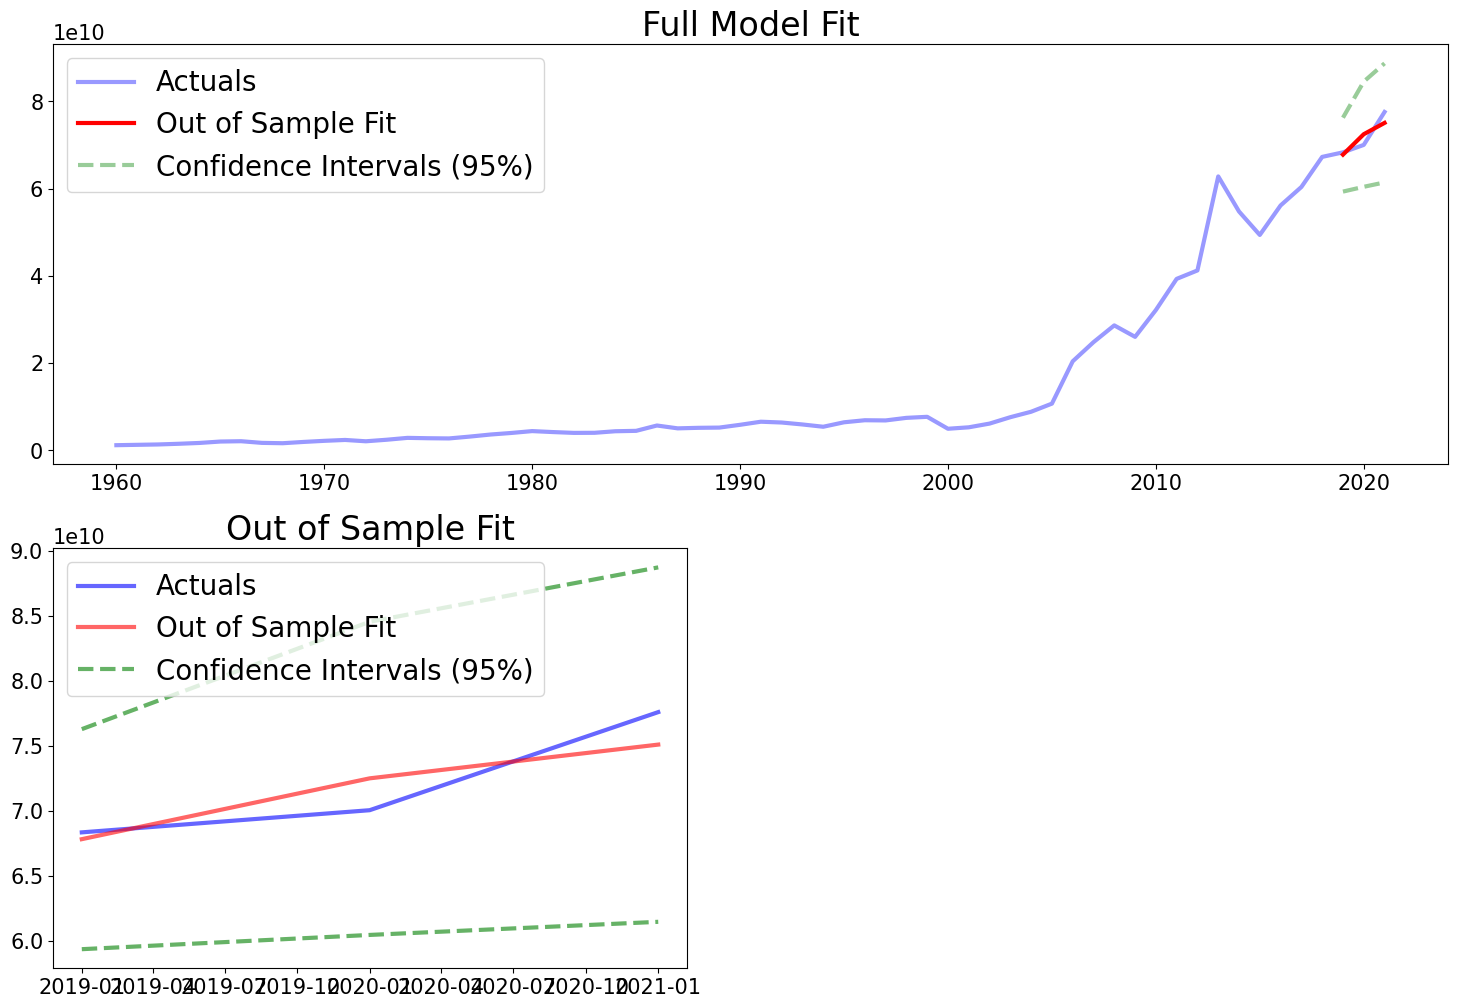

In [68]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)
plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Вывод: Модель должна лучше определять, но по графику это не сильно заметно. Скорей всего это связано с небольшим улучшением модели, и небольшой тренировочной и тестовой выборкой.

# Модели прогнозирования гетероскедастичности. Валидация временных рядов.

1) Посчитайте волатильность для вашего временного ряда.

In [69]:
df["GDP_vol"] = df["GDP (current US$)"].pct_change(1).mul(100).abs()
df["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

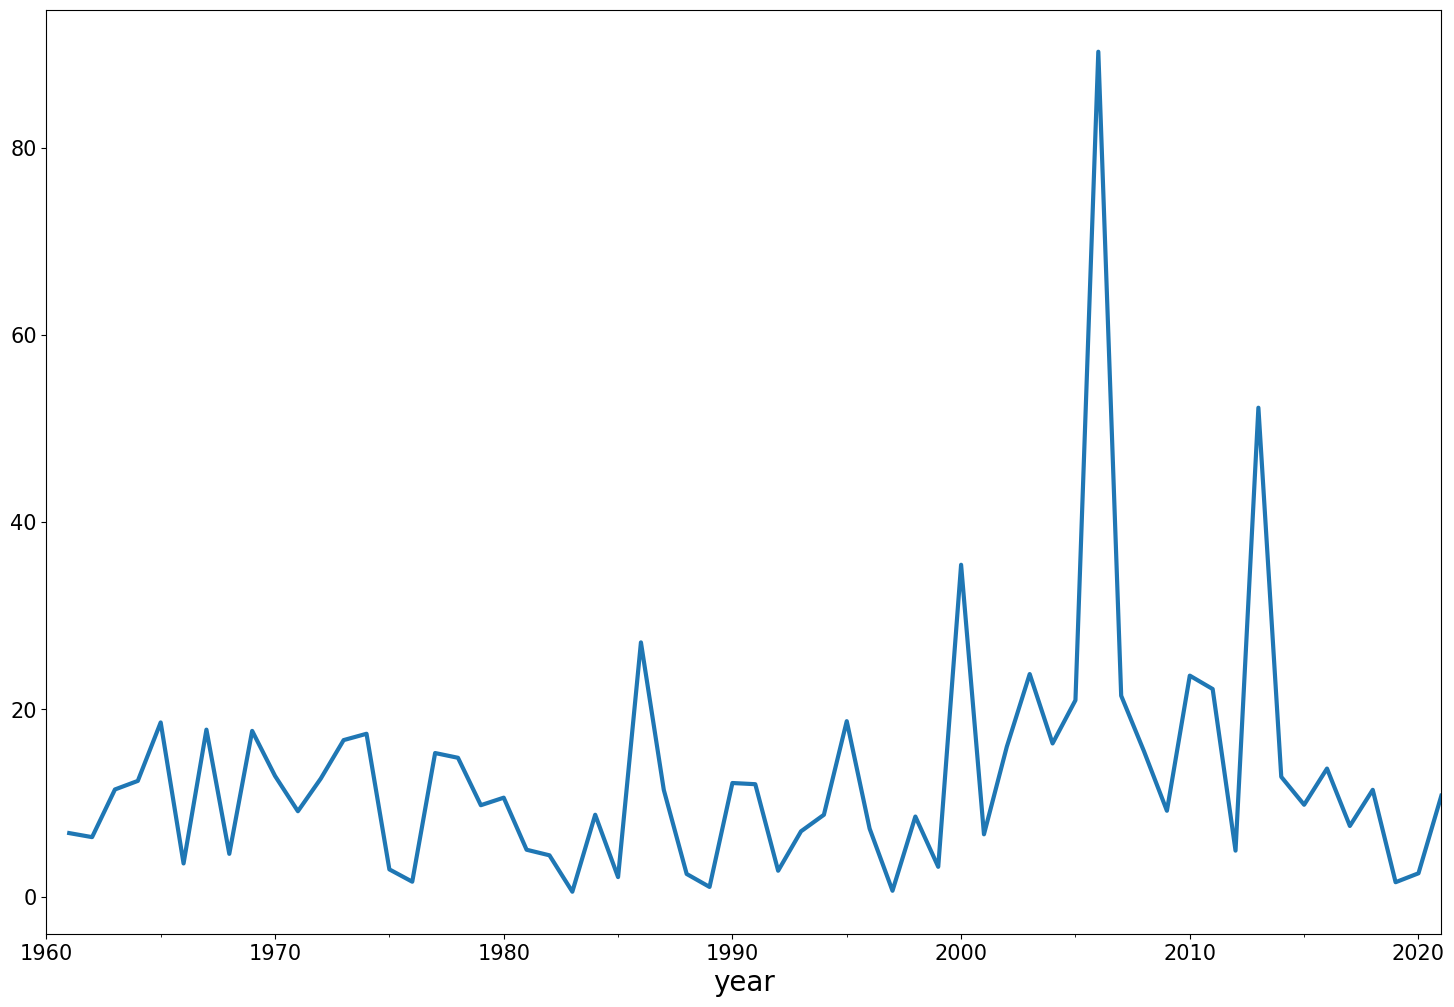

In [70]:
df["GDP_vol"].plot()
plt.show()

In [71]:
# Разделим выборку на обучающую и тестовую
train_vol_df = df.loc[:"2018-01-01"]
test_vol_df = df.loc["2019-01-01":]

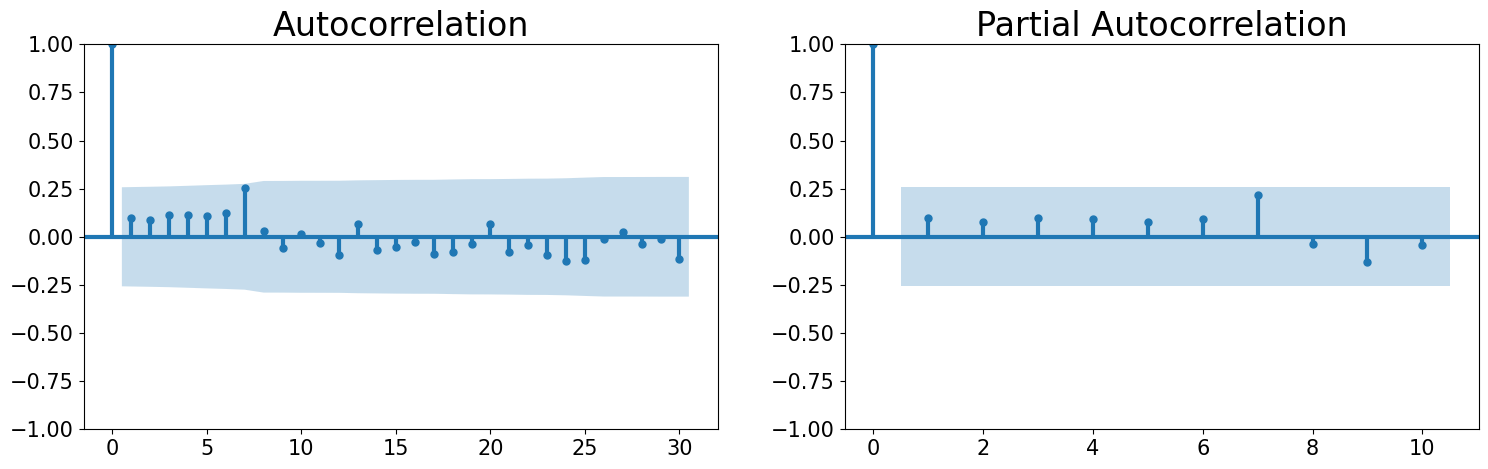

In [72]:
plot_acf_pacf(train_vol_df.GDP_vol[1:])

In [73]:
adfuller(train_vol_df.GDP_vol[1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд стационарен. 

2) Используйте GARCH-модель для предсказания волатильности.

Итак, мы построим модель GARCH(1, 1).

In [82]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(df["GDP_vol"].loc[df.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
garch_df.loc[train_vol_df.index, "GDP_vol"] = train_vol_df["GDP_vol"].dropna()

In [83]:
model_ar = arch_model(garch_df["GDP_vol"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results_ar = model_ar.fit(last_obs=test_vol_df.index[0])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.9755861825515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551668535086
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253911783457
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.153813350104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.88223730003082
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.3848318221798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.38840967935226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.23867960370163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.90954513471712
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.87183210880022
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.92958507527516
Iteration:     14,   Func. Count:     83,   Neg. LLF: 22

In [84]:
model_results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Wed, Sep 20 2023   Df Residuals:                       57
Time:                        14:42:42   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [85]:
predictions_df = test_vol_df.copy()
predictions_df["Predictions"] = model_results_ar.forecast().residual_variance.loc[
    test_vol_df.index
]

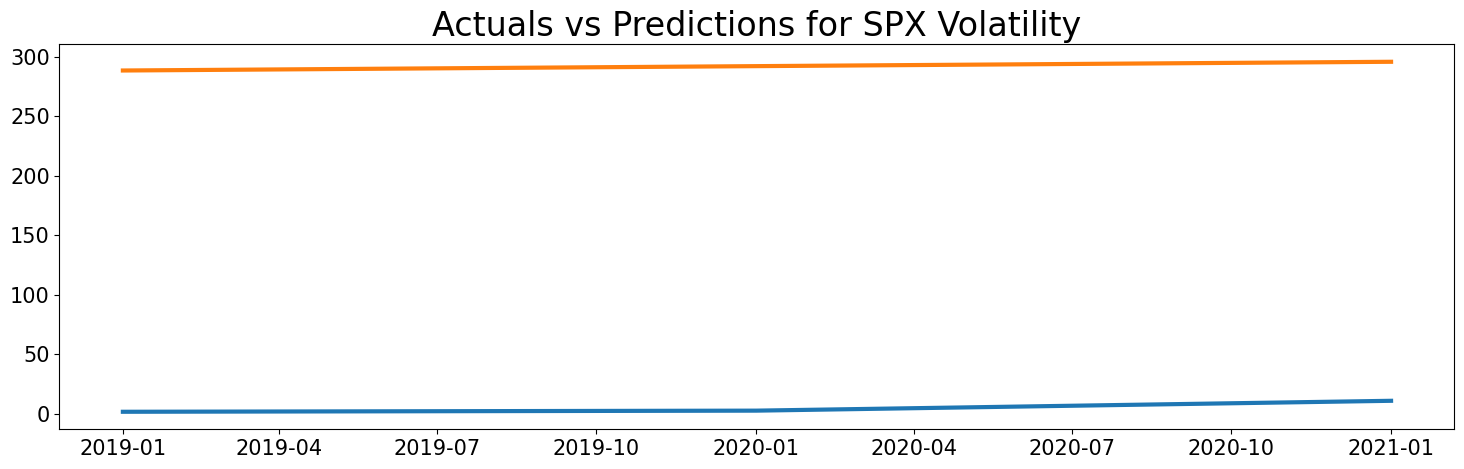

In [86]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [87]:
mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

82531.24159419035

3) Используйте линейную регрессию для получения прогноза. Визуализируйте полученное предсказание вместе с фактическим значением.

In [88]:
X_train = pd.DataFrame(range(df["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_vol_df["GDP_vol"].fillna(0)
y_test = test_vol_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


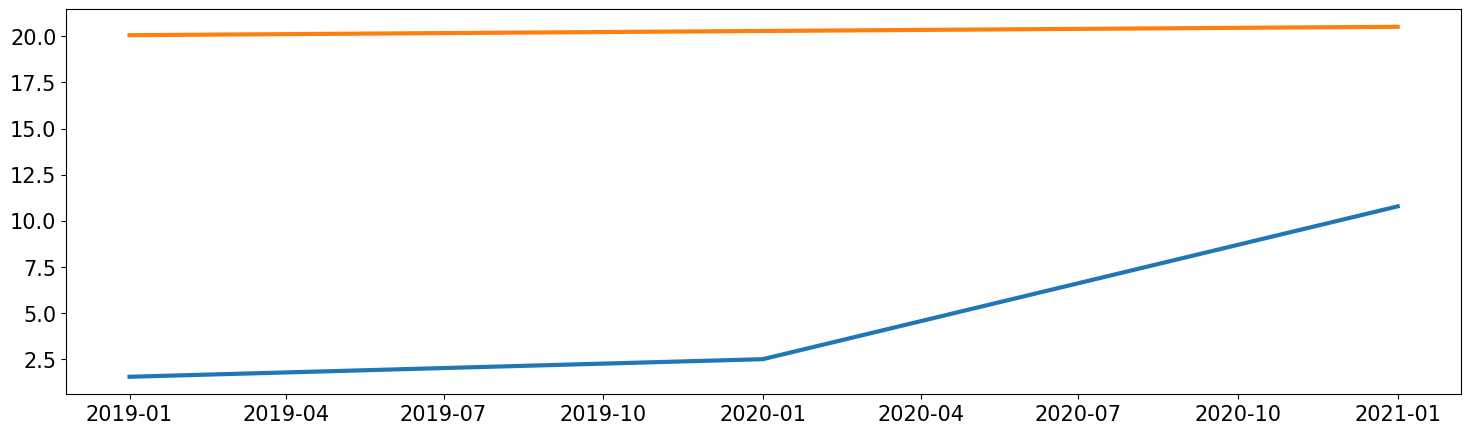

In [89]:
plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

4) Сравните результаты и сделайте выводы. Почему результат модели GARCH получился именно таким?

Вывод: исходя из графиков сложно выбрать модель, которая справилась лучше. С моей точки зрения, результат не очень. Это может быть связанно с маленьким объёмом информации. 

Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. 